In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

# Leer el archivo de Excel
filename ='/content/drive/My Drive/Colab Notebooks/Notebooks/Base Demanda Diaria 2017 2023.xlsx'
Sheet_DatosRegion = 'Datos Región'
df = pd.read_excel(filename, sheet_name=Sheet_DatosRegion)

# prompt: Quiero agregar una columna al data set df. Debe tener valor 2, 1 o 0 dependiendo si en la columna Tipo día dice la palabara feriado, semilaboral o no.

df['Tipo_dia_valor'] = df['Tipo día'].apply(lambda x: 1 if 'feriado' in x.lower() else 2 if 'semilaborable' in x.lower() else 0)

# prompt: Quiero agregar una columna al data set df. Debe tener el numero del mes de la columna MES

df['MES_NUM'] = pd.to_datetime(df['MES'], format='%d-%m-%Y').dt.month

# prompt: quiero mostrar solo las columnas de interes

df = df.rename(columns={'GRAN BS.AS.': 'Demanda_Diaria'})
df = df.rename(columns={'TEMPERATURA REFERENCIA MEDIA GBA °C': 'TEMPERATURA_MEDIA'})

df = df[['AÑO','Fecha','MES_NUM', 'Tipo_dia_valor', 'TEMPERATURA_MEDIA','Demanda_Diaria']]

Mounted at /content/drive


# **Instalación del paquete EMD-signal**

In [ ]:
# install the package which is necessary for frequency decomposition
! pip install EMD-signal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.1 MB/s eta 0:00:00


# Acá aplicamos primero la descoposición en modos y luego la CNN

15/15 [==============================] - 0s 2ms/step
Train RMSE: 130.09506132752148
Test RMSE: 451.74444969791085


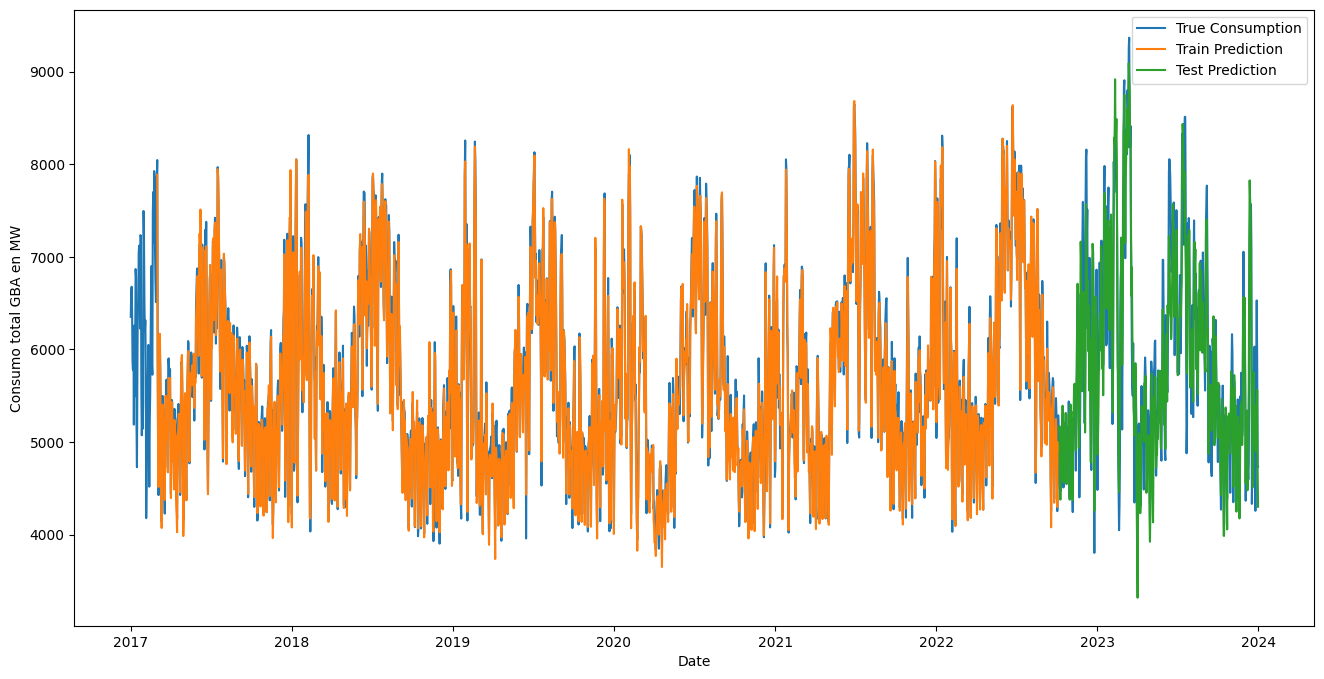

In [ ]:
# First **EMD** and then CNN
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import EMD
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Parameters
split_ratio = 0.8
epochs = 50
batch_size = 32
look_back = 60


# Preprocess data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Demanda_Diaria']])

# Empirical Mode Decomposition (EMD)
emd = EMD()
IMFs = emd.emd(scaled_data.flatten())

# Function to create dataset for CNN
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back)]
        X.append(a)
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)

# Split data into training and testing sets
train_size = int(len(IMFs[0]) * split_ratio)
test_size = len(IMFs[0]) - train_size

train_predict_list = []
test_predict_list = []
train_actual = []
test_actual = []

# Loop through each IMF and predict using CNN
for imf in IMFs:
    X, Y = create_dataset(imf.reshape(-1, 1), look_back)

    X_train, X_test = X[:train_size], X[train_size:]
    Y_train, Y_test = Y[:train_size], Y[train_size:]

    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Build the CNN model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(look_back, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0)

    # Make predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    train_predict_list.append(train_predict)
    test_predict_list.append(test_predict)
    train_actual.append(Y_train)
    test_actual.append(Y_test)

# Sum predictions of all IMFs to get the final prediction
train_predict_final = np.sum(train_predict_list, axis=0)
test_predict_final = np.sum(test_predict_list, axis=0)
train_actual_final = np.sum(train_actual, axis=0)
test_actual_final = np.sum(test_actual, axis=0)

# Invert predictions and actual values to original scale
train_predict_final = scaler.inverse_transform(train_predict_final)
train_actual_final = scaler.inverse_transform(train_actual_final)
test_predict_final = scaler.inverse_transform(test_predict_final)
test_actual_final = scaler.inverse_transform(test_actual_final)

# Calculate RMSE
train_score = np.sqrt(mean_squared_error(train_actual_final[:, 0], train_predict_final[:, 0]))
test_score = np.sqrt(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0]))
print(f'Train RMSE: {train_score}')
print(f'Test RMSE: {test_score}')

# Plot the results
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[look_back:len(train_predict_final) + look_back, :] = train_predict_final

test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict_final) + (look_back * 1):len(scaled_data), :] = test_predict_final

plt.figure(figsize=(16,8))
plt.plot(df['Fecha'], df['Demanda_Diaria'], label='True Consumption')
plt.plot(df['Fecha'], pd.DataFrame(train_plot, index=df.index), label='Train Prediction')
plt.plot(df['Fecha'], pd.DataFrame(test_plot, index=df.index), label='Test Prediction')
plt.xlabel('Date')
plt.ylabel('Consumo total GBA en MW')
plt.legend()
plt.show()


# Acá aplicamos primero la descoposición en modos (CEEMDAN) y luego la LSTM y CNN-LSTM

15/15 [==============================] - 0s 20ms/step
Train RMSE: 282.51192939369963
Test RMSE: 304.0062191364775
Tiempo de procesamiento: 1911.7937994003296 segundos


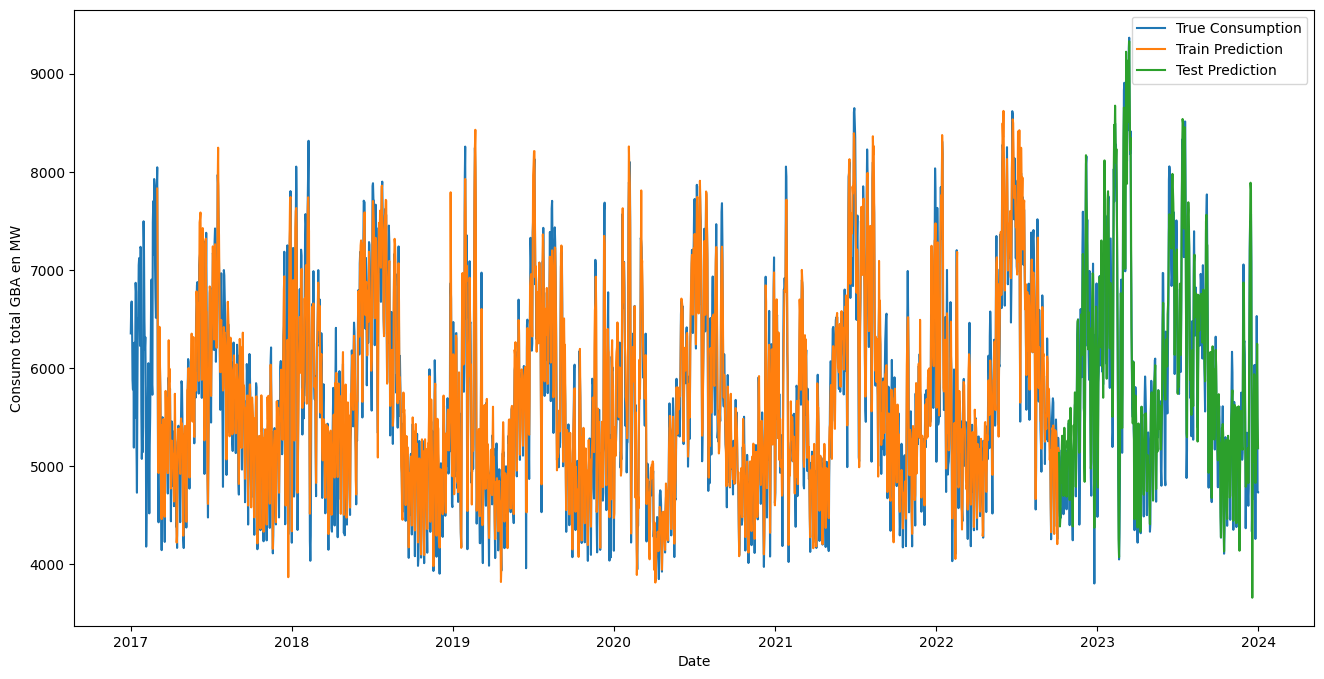

In [ ]:
# We use here *Complete Ensemble* EMD first, and the an LSTM forecast.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import CEEMDAN # acalarar que para estos modelos se utilza este modo porque da mejor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import time

# Parameters
split_ratio = 0.8
epochs = 50
batch_size = 32
look_back = 60

# Calcular el tiempo de procesamiento
start_time = time.time()

# Preprocess data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Demanda_Diaria']])

# Ensemble Empirical Mode Decomposition (EEMD)
ceemdan = CEEMDAN()

#IMFs = ceemdan(scaled_data.flatten(), None, 3) jugar con diferentes valores de la generación de funciones
IMFs = ceemdan(scaled_data.flatten())

# Function to create dataset for LSTM
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back)]
        X.append(a)
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)

# Split data into training and testing sets
train_size = int(len(IMFs[0]) * split_ratio)
test_size = len(IMFs[0]) - train_size

train_predict_list = []
test_predict_list = []
train_actual = []
test_actual = []

# Loop through each IMF and predict using LSTM
for imf in IMFs:
    X, Y = create_dataset(imf.reshape(-1, 1), look_back)

    X_train, X_test = X[:train_size], X[train_size:]
    Y_train, Y_test = Y[:train_size], Y[train_size:]

    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0)

    # Make predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    train_predict_list.append(train_predict)
    test_predict_list.append(test_predict)
    train_actual.append(Y_train)
    test_actual.append(Y_test)

# Sum predictions of all IMFs to get the final prediction
train_predict_final = np.sum(train_predict_list, axis=0)
test_predict_final = np.sum(test_predict_list, axis=0)
train_actual_final = np.sum(train_actual, axis=0)
test_actual_final = np.sum(test_actual, axis=0)

# Invert predictions and actual values to original scale
train_predict_final = scaler.inverse_transform(train_predict_final)
train_actual_final = scaler.inverse_transform(train_actual_final)
test_predict_final = scaler.inverse_transform(test_predict_final)
test_actual_final = scaler.inverse_transform(test_actual_final)

# Calculate RMSE
train_score = np.sqrt(mean_squared_error(train_actual_final[:, 0], train_predict_final[:, 0]))
test_score = np.sqrt(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0]))
print(f'Train RMSE: {train_score}')
print(f'Test RMSE: {test_score}')

# Plot the results
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[look_back:len(train_predict_final) + look_back, :] = train_predict_final

test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict_final) + (look_back * 1):len(scaled_data), :] = test_predict_final

end_time = time.time()
# Calcular el tiempo total de procesamiento
total_time = end_time - start_time
print("Tiempo de procesamiento:", total_time, "segundos")

plt.figure(figsize=(16,8))
plt.plot(df['Fecha'], df['Demanda_Diaria'], label='True Consumption')
plt.plot(df['Fecha'], pd.DataFrame(train_plot, index=df.index), label='Train Prediction')
plt.plot(df['Fecha'], pd.DataFrame(test_plot, index=df.index), label='Test Prediction')
plt.xlabel('Date')
plt.ylabel('Consumo total GBA en MW')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

lstm_emd_mae = mean_absolute_error(test_actual_final[:, 0], test_predict_final[:, 0])
lstm_emd_mape = mean_absolute_percentage_error(test_actual_final[:, 0], test_predict_final[:, 0])

print("LSTM EMD MAE:", lstm_emd_mae)
print("LSTM EMD MAPE:", lstm_emd_mape*100)

LSTM EMD MAE: 239.79143416269125
LSTM EMD MAPE: 4.107474484290342


14/14 [==============================] - 0s 5ms/step
Train RMSE: 218.10568889909723
Test RMSE: 305.14276841140907


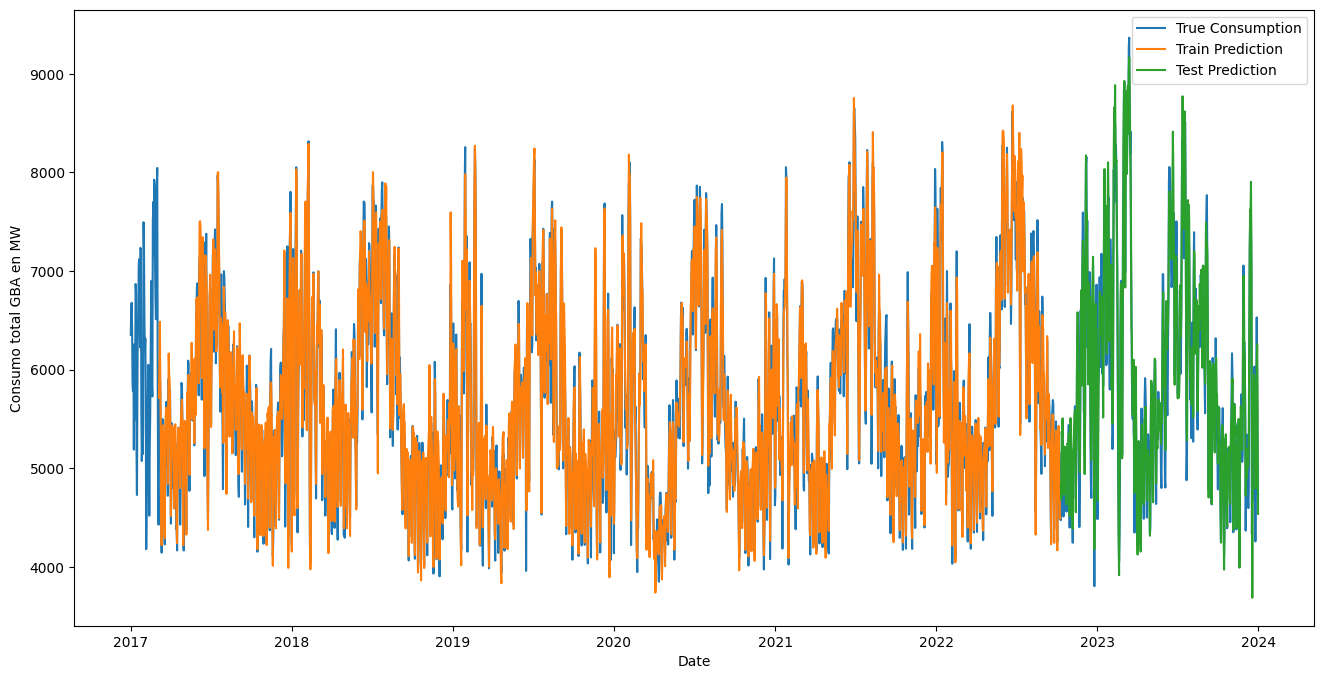

In [ ]:
# We use here *Complete Ensemble* EMD first, and the an CNN-LSTM forecast.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import CEEMDAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Conv1D, Flatten, MaxPooling1D, TimeDistributed

# Parameters
split_ratio = 0.8
epochs = 50
batch_size = 32
look_back = 64
n_seq = 4
n_steps = 16


# Preprocess data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Demanda_Diaria']])

# Ensemble Empirical Mode Decomposition (EEMD)
ceemdan = CEEMDAN()
IMFs = ceemdan(scaled_data.flatten())

# Function to create dataset for LSTM
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back)]
        X.append(a)
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)

# Split data into training and testing sets
train_size = int(len(IMFs[0]) * split_ratio)
test_size = len(IMFs[0]) - train_size

train_predict_list = []
test_predict_list = []
train_actual = []
test_actual = []

# Loop through each IMF and predict using LSTM
for imf in IMFs:
    X, Y = create_dataset(imf.reshape(-1, 1), look_back)

    X_train, X_test = X[:train_size], X[train_size:]
    Y_train, Y_test = Y[:train_size], Y[train_size:]

    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], n_seq, n_steps, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], n_seq, n_steps, 1))
    # Build the LSTM model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=32, kernel_size=1, activation='relu'), input_shape=(None, n_steps, 1)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0)

    # Make predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    train_predict_list.append(train_predict)
    test_predict_list.append(test_predict)
    train_actual.append(Y_train)
    test_actual.append(Y_test)

# Sum predictions of all IMFs to get the final prediction
train_predict_final = np.sum(train_predict_list, axis=0)
test_predict_final = np.sum(test_predict_list, axis=0)
train_actual_final = np.sum(train_actual, axis=0)
test_actual_final = np.sum(test_actual, axis=0)

# Invert predictions and actual values to original scale
train_predict_final = scaler.inverse_transform(train_predict_final)
train_actual_final = scaler.inverse_transform(train_actual_final)
test_predict_final = scaler.inverse_transform(test_predict_final)
test_actual_final = scaler.inverse_transform(test_actual_final)

# Calculate RMSE
train_score = np.sqrt(mean_squared_error(train_actual_final[:, 0], train_predict_final[:, 0]))
test_score = np.sqrt(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0]))
print(f'Train RMSE: {train_score}')
print(f'Test RMSE: {test_score}')

# Plot the results
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[look_back:len(train_predict_final) + look_back, :] = train_predict_final

test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict_final) + (look_back * 1):len(scaled_data), :] = test_predict_final

plt.figure(figsize=(16,8))
plt.plot(df['Fecha'], df['Demanda_Diaria'], label='True Consumption')
plt.plot(df['Fecha'], pd.DataFrame(train_plot, index=df.index), label='Train Prediction')
plt.plot(df['Fecha'], pd.DataFrame(test_plot, index=df.index), label='Test Prediction')
plt.xlabel('Date')
plt.ylabel('Consumo total GBA en MW')
plt.legend()
plt.show()

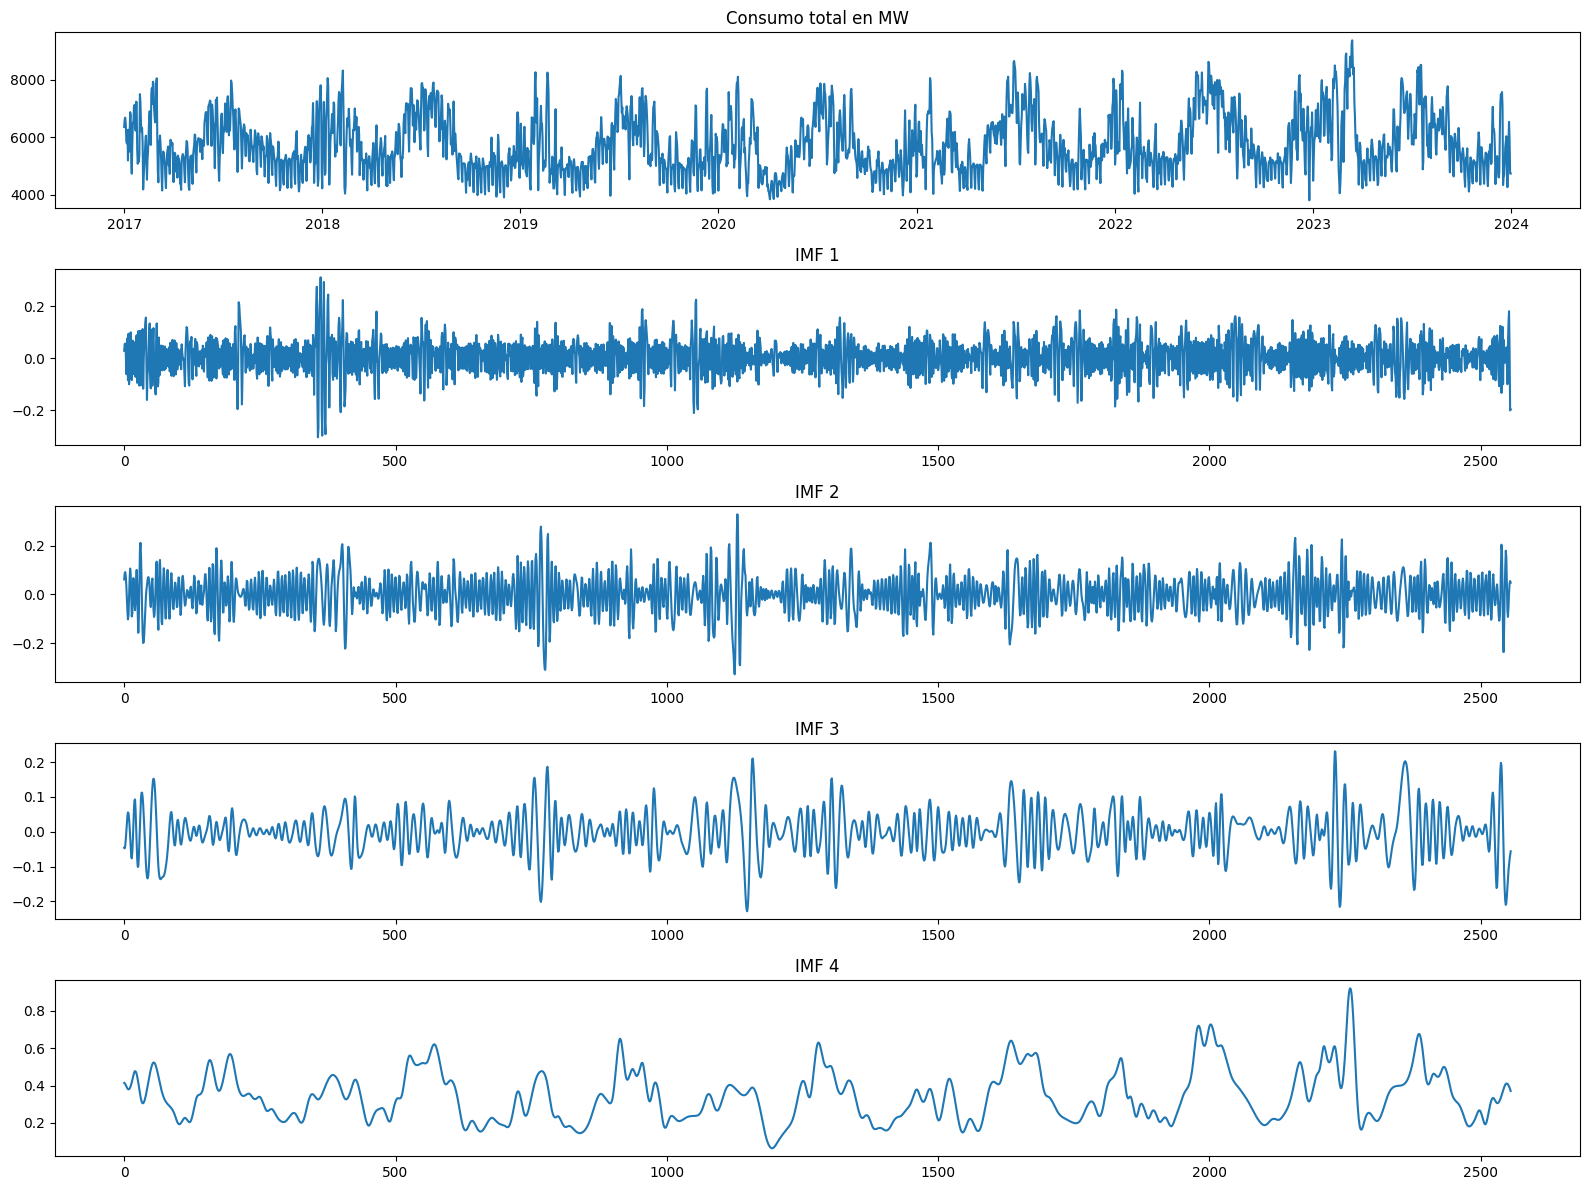

In [ ]:
import matplotlib.pyplot as plt

# Define the number of IMFs
n_imfs = len(IMFs)

# Create a figure with subplots
fig, axes = plt.subplots(n_imfs + 1, 1, figsize=(16, 12))

axes[0].plot(df['Fecha'], df['Demanda_Diaria'])
axes[0].set_title('Consumo total en MW')

# Plot each IMF in a separate subplot
for i in range(n_imfs):
    axes[i+1].plot(IMFs[i])
    axes[i+1].set_title('IMF {}'.format(i + 1))

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


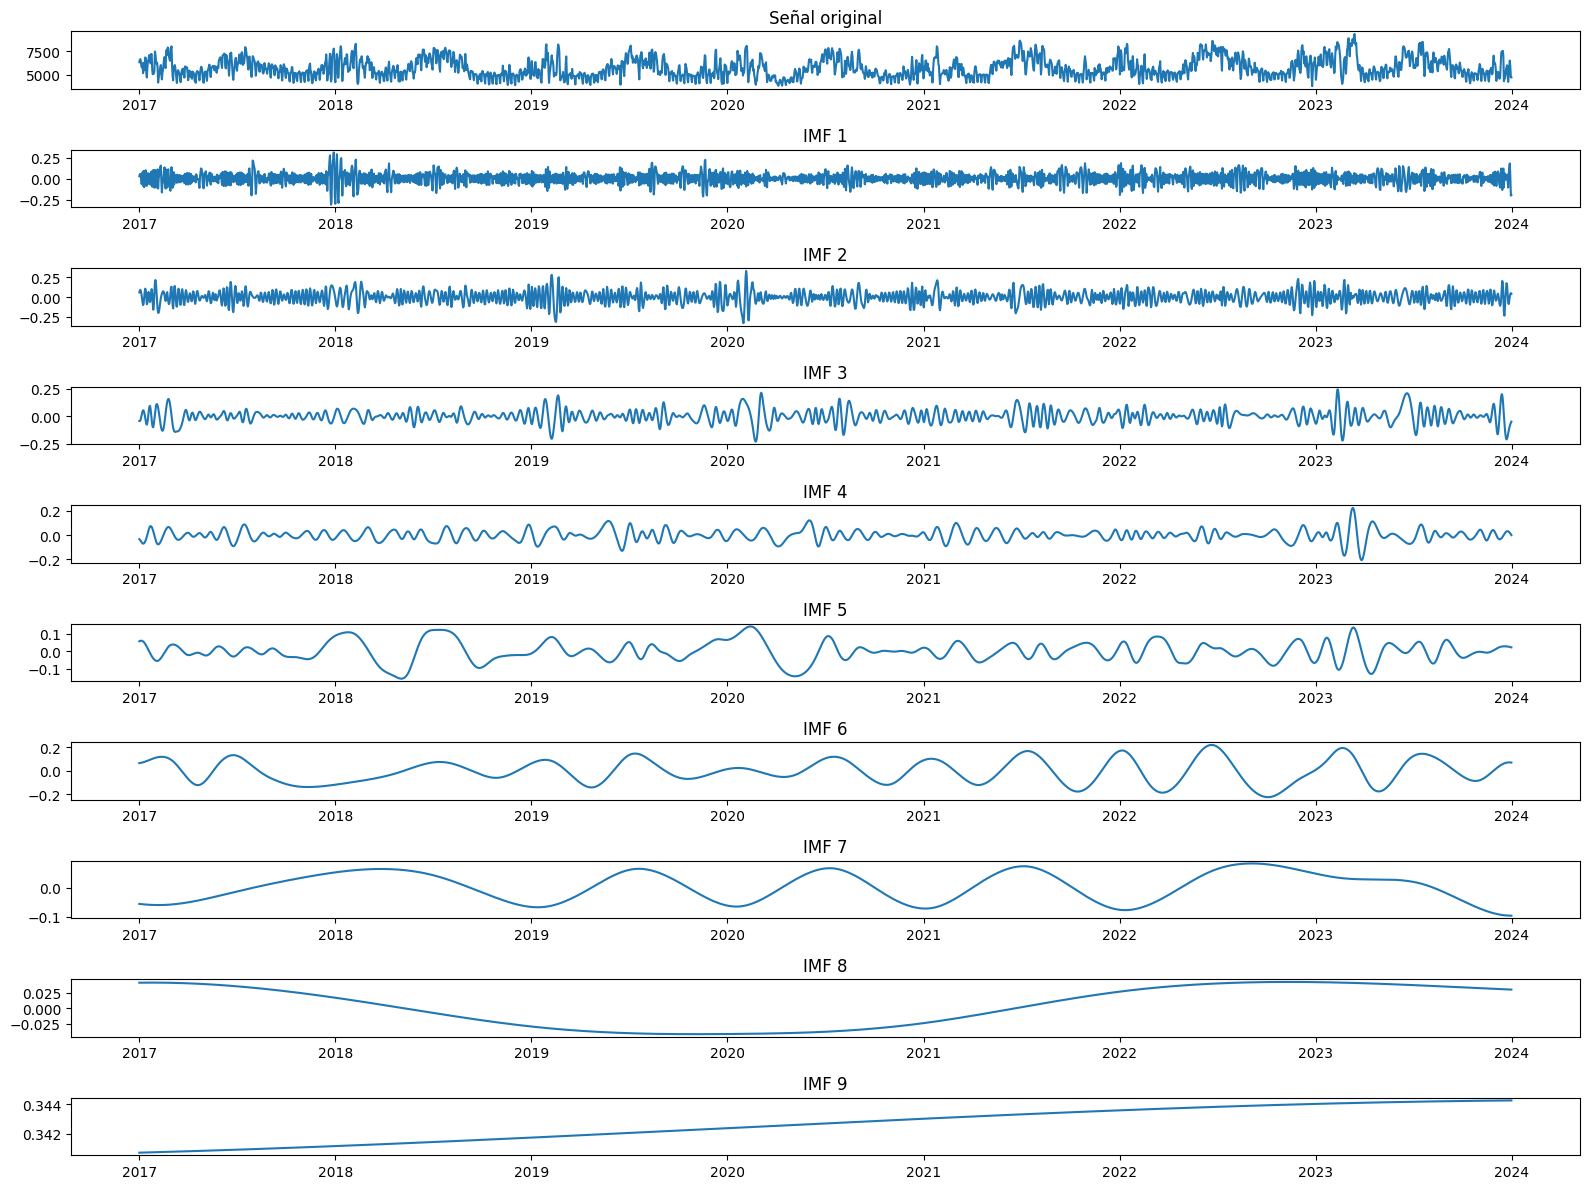

In [ ]:
import matplotlib.pyplot as plt

# Define the number of IMFs
n_imfs = len(IMFs)

# Create a figure with subplots
fig, axes = plt.subplots(n_imfs + 1, 1, figsize=(16, 12))

axes[0].plot(df['Fecha'], df['Demanda_Diaria'])
axes[0].set_title('Señal original')

# Plot each IMF in a separate subplot
for i in range(n_imfs):
    axes[i+1].plot(df['Fecha'], IMFs[i])
    axes[i+1].set_title('IMF {}'.format(i + 1))

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


# Predicción con datos Reales

Se obtiene los datos intradiarios obtenidos del mismo data set pero de manera diaria con una automatización en Power Automate

In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

# Leer el archivo de Excel
filename ='/content/drive/My Drive/Colab Notebooks/Notebooks/LimpiezaDeArchivos.xlsm'
Sheet_Datos = 'Hoja1'
df = pd.read_excel(filename, sheet_name=Sheet_Datos)


Mounted at /content/drive


Con una 1 IMF

3/3 [==============================] - 0s 5ms/step
Test RMSE: 585.8175484915961
Test MAE: 408.07593994140626
Test MAPE: 7.319708279151143
Tiempo de procesamiento: 21.40442180633545 segundos


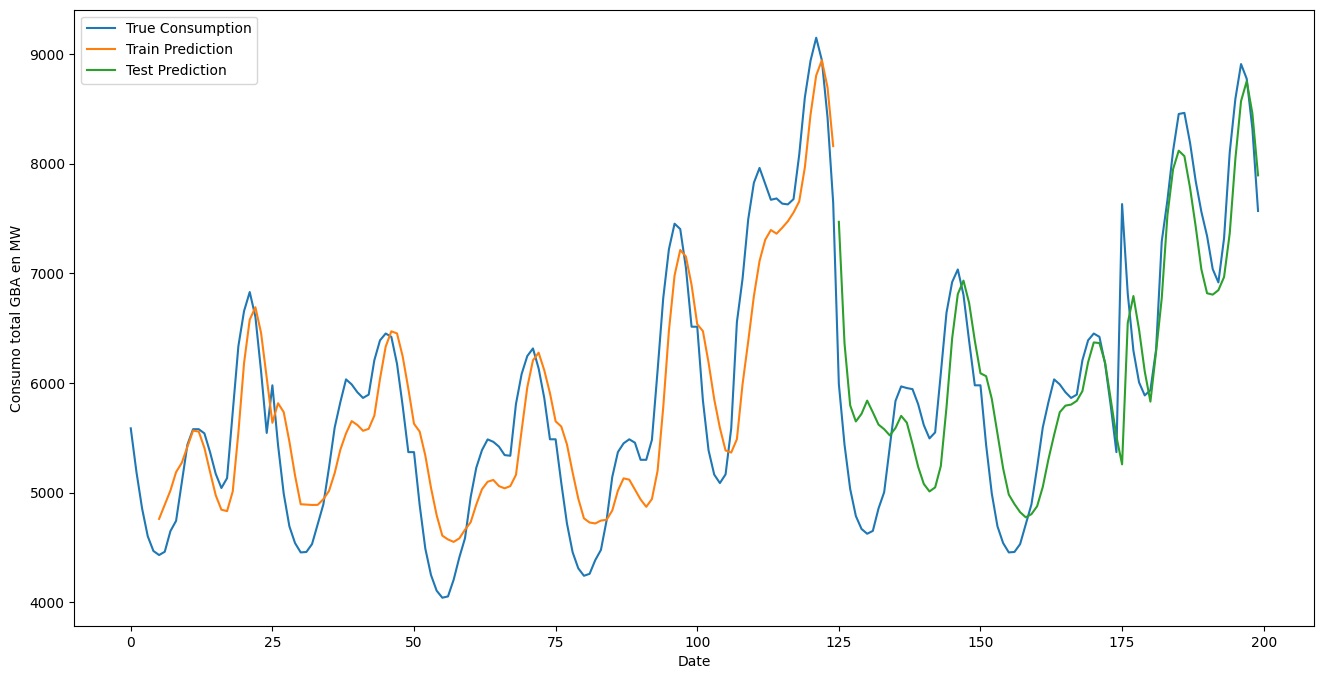

In [ ]:
# We use here *Complete Ensemble* EMD first, and the an LSTM forecast.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import CEEMDAN # acalarar que para estos modelos se utilza este modo porque da mejor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import time

# Parameters
split_ratio = 0.6
epochs = 50
batch_size = 32
look_back = 5

# Calcular el tiempo de procesamiento
start_time = time.time()

# Preprocess data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Consumo']])

# Ensemble Empirical Mode Decomposition (EEMD)
ceemdan = CEEMDAN()

IMFs = ceemdan(scaled_data.flatten(), None, 1)

# Function to create dataset for LSTM
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back)]
        X.append(a)
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)

# Split data into training and testing sets
train_size = int(len(IMFs[0]) * split_ratio)
test_size = len(IMFs[0]) - train_size

train_predict_list = []
test_predict_list = []
train_actual = []
test_actual = []

# Loop through each IMF and predict using LSTM
for imf in IMFs:
    X, Y = create_dataset(imf.reshape(-1, 1), look_back)

    X_train, X_test = X[:train_size], X[train_size:]
    Y_train, Y_test = Y[:train_size], Y[train_size:]

    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0)

    # Make predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    train_predict_list.append(train_predict)
    test_predict_list.append(test_predict)
    train_actual.append(Y_train)
    test_actual.append(Y_test)

# Sum predictions of all IMFs to get the final prediction
train_predict_final = np.sum(train_predict_list, axis=0)
test_predict_final = np.sum(test_predict_list, axis=0)
train_actual_final = np.sum(train_actual, axis=0)
test_actual_final = np.sum(test_actual, axis=0)

# Invert predictions and actual values to original scale
train_predict_final = scaler.inverse_transform(train_predict_final)
train_actual_final = scaler.inverse_transform(train_actual_final)
test_predict_final = scaler.inverse_transform(test_predict_final)
test_actual_final = scaler.inverse_transform(test_actual_final)

# Calculate RMSE
train_score = np.sqrt(mean_squared_error(train_actual_final[:, 0], train_predict_final[:, 0]))
test_score = np.sqrt(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0]))
test_score_mae = mean_absolute_error(train_actual_final[:, 0], train_predict_final[:, 0])
test_score_mape = mean_absolute_percentage_error(train_actual_final[:, 0], train_predict_final[:, 0])*100

print(f'Test RMSE: {test_score}')
print(f'Test MAE: {test_score_mae}')
print(f'Test MAPE: {test_score_mape}')

# Plot the results
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[look_back:len(train_predict_final) + look_back, :] = train_predict_final

test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict_final) + (look_back * 1):len(scaled_data), :] = test_predict_final

end_time = time.time()
# Calcular el tiempo total de procesamiento
total_time = end_time - start_time
print("Tiempo de procesamiento:", total_time, "segundos")

plt.figure(figsize=(16,8))
plt.plot(df['Consumo'], label='True Consumption')
plt.plot(pd.DataFrame(train_plot, index=df.index), label='Train Prediction')
plt.plot(pd.DataFrame(test_plot, index=df.index), label='Test Prediction')
plt.xlabel('Date')
plt.ylabel('Consumo total GBA en MW')
plt.legend()
plt.show()

Con una IMF 2

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Test RMSE: 505.04116234241087
Test MAE: 160.25471679687504
Test MAPE: 2.922596974469699
Tiempo de procesamiento: 47.79440140724182 segundos


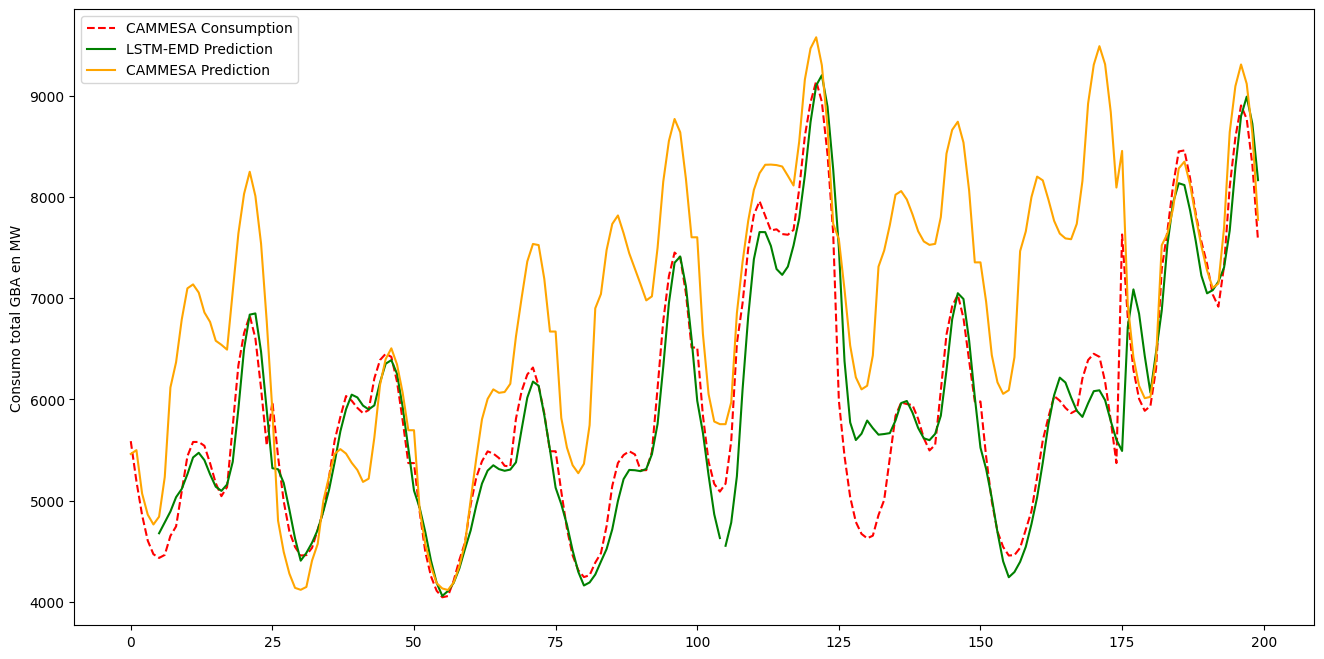

In [ ]:
# We use here *Complete Ensemble* EMD first, and the an LSTM forecast.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import CEEMDAN # acalarar que para estos modelos se utilza este modo porque da mejor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import time

# Parameters
split_ratio = 0.5
epochs = 50
batch_size = 32
look_back = 5

# Calcular el tiempo de procesamiento
start_time = time.time()

# Preprocess data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Consumo']])

# Ensemble Empirical Mode Decomposition (EEMD)
ceemdan = CEEMDAN()

IMFs = ceemdan(scaled_data.flatten())

# Function to create dataset for LSTM
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back)]
        X.append(a)
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)

# Split data into training and testing sets
train_size = int(len(IMFs[0]) * split_ratio)
test_size = len(IMFs[0]) - train_size

train_predict_list = []
test_predict_list = []
train_actual = []
test_actual = []

# Loop through each IMF and predict using LSTM
for imf in IMFs:
    X, Y = create_dataset(imf.reshape(-1, 1), look_back)

    X_train, X_test = X[:train_size], X[train_size:]
    Y_train, Y_test = Y[:train_size], Y[train_size:]

    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0)

    # Make predictions
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    train_predict_list.append(train_predict)
    test_predict_list.append(test_predict)
    train_actual.append(Y_train)
    test_actual.append(Y_test)

# Sum predictions of all IMFs to get the final prediction
train_predict_final = np.sum(train_predict_list, axis=0)
test_predict_final = np.sum(test_predict_list, axis=0)
train_actual_final = np.sum(train_actual, axis=0)
test_actual_final = np.sum(test_actual, axis=0)

# Invert predictions and actual values to original scale
train_predict_final = scaler.inverse_transform(train_predict_final)
train_actual_final = scaler.inverse_transform(train_actual_final)
test_predict_final = scaler.inverse_transform(test_predict_final)
test_actual_final = scaler.inverse_transform(test_actual_final)

# Calculate RMSE
train_score = np.sqrt(mean_squared_error(train_actual_final[:, 0], train_predict_final[:, 0]))
test_score = np.sqrt(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0]))
test_score_mae = mean_absolute_error(train_actual_final[:, 0], train_predict_final[:, 0])
test_score_mape = mean_absolute_percentage_error(train_actual_final[:, 0], train_predict_final[:, 0])*100

print(f'Test RMSE: {test_score}')
print(f'Test MAE: {test_score_mae}')
print(f'Test MAPE: {test_score_mape}')

# Plot the results
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[look_back:len(train_predict_final) + look_back, :] = train_predict_final

test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(train_predict_final) + (look_back * 1):len(scaled_data), :] = test_predict_final

end_time = time.time()
# Calcular el tiempo total de procesamiento
total_time = end_time - start_time
print("Tiempo de procesamiento:", total_time, "segundos")

plt.figure(figsize=(16,8))
plt.plot(df['Consumo'], label='CAMMESA Consumption',color = 'red' ,linestyle = "--")
plt.plot(pd.DataFrame(train_plot, index=df.index), color='green')
plt.plot(pd.DataFrame(test_plot, index=df.index), label='LSTM-EMD Prediction', color='green')
plt.plot(df['Prevista'], label='CAMMESA Prediction', color='orange')
plt.ylabel('Consumo total GBA en MW')
plt.legend()
plt.show()

Hacer un grafico de cajas similar a como se hizo con los errores y preparar una constante del error de camesa

In [ ]:
# We use here *Complete Ensemble* EMD first, and the an LSTM forecast.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import CEEMDAN # acalarar que para estos modelos se utilza este modo porque da mejor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import time

# Parameters
split_ratio = 0.8
epochs = 50
batch_size = 32
look_back = 5

# Calcular el tiempo de procesamiento
start_time = time.time()

# Obtengo la cantidad total del tamaño
longitud_df_procesado = len(df)
# La longitud limite es hasta llegar al 40% del data set
longitud_limite = longitud_df_procesado * 0.6
# Inicialización de variables
iteraciones = 0
test_data = []
list_lstm_emd_mse = []
list_lstm_emd_rmse = []
list_lstm_emd_mae = []

while not(longitud_df_procesado < longitud_limite):

  Total_datos = longitud_df_procesado

  # Download data
  data = df[['Consumo']].head(Total_datos)

  # Preprocess data
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_data = scaler.fit_transform(data)

  # Ensemble Empirical Mode Decomposition (EEMD)
  ceemdan = CEEMDAN()
  IMFs = ceemdan(scaled_data.flatten())

  # Function to create dataset for LSTM
  def create_dataset(data, look_back=1):
      X, Y = [], []
      for i in range(len(data) - look_back):
          a = data[i:(i + look_back)]
          X.append(a)
          Y.append(data[i + look_back])
      return np.array(X), np.array(Y)

  # Split data into training and testing sets
  train_size = int(len(IMFs[0]) * split_ratio)
  test_size = len(IMFs[0]) - train_size

  train_predict_list = []
  test_predict_list = []
  train_actual = []
  test_actual = []

  # Loop through each IMF and predict using LSTM
  for imf in IMFs:
      X, Y = create_dataset(imf.reshape(-1, 1), look_back)

      X_train, X_test = X[:train_size], X[train_size:]
      Y_train, Y_test = Y[:train_size], Y[train_size:]

      # Reshape input to be [samples, time steps, features]
      X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
      X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

      # Build the LSTM model
      model = Sequential()
      model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
      model.add(LSTM(50, return_sequences=False))
      model.add(Dense(25))
      model.add(Dense(1))

      # Compile the model
      model.compile(optimizer='adam', loss='mean_squared_error')

      # Train the model
      model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0)

      # Make predictions
      train_predict = model.predict(X_train)
      test_predict = model.predict(X_test)

      train_predict_list.append(train_predict)
      test_predict_list.append(test_predict)
      train_actual.append(Y_train)
      test_actual.append(Y_test)

  # Sum predictions of all IMFs to get the final prediction
  train_predict_final = np.sum(train_predict_list, axis=0)
  test_predict_final = np.sum(test_predict_list, axis=0)
  train_actual_final = np.sum(train_actual, axis=0)
  test_actual_final = np.sum(test_actual, axis=0)

  # Invert predictions and actual values to original scale
  train_predict_final = scaler.inverse_transform(train_predict_final)
  train_actual_final = scaler.inverse_transform(train_actual_final)
  test_predict_final = scaler.inverse_transform(test_predict_final)
  test_actual_final = scaler.inverse_transform(test_actual_final)

  # Calculate RMSE
  train_score = np.sqrt(mean_squared_error(train_actual_final[:, 0], train_predict_final[:, 0]))
  test_score = np.sqrt(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0]))
  test_score_mae = mean_absolute_error(train_actual_final[:, 0], train_predict_final[:, 0])
  test_score_mape = mean_absolute_percentage_error(train_actual_final[:, 0], train_predict_final[:, 0])*100

  # Append the results to the lists
  list_lstm_emd_mse.append(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0]))
  list_lstm_emd_rmse.append(np.sqrt(mean_squared_error(test_actual_final[:, 0], test_predict_final[:, 0])))
  list_lstm_emd_mae.append(mean_absolute_error(train_actual_final[:, 0], train_predict_final[:, 0]))

  longitud_df_procesado = longitud_df_procesado - len(X_test)

end_time = time.time()
# Calcular el tiempo total de procesamiento
total_time = end_time - start_time
print("Tiempo de procesamiento:", total_time, "segundos")

1/1 [==============================] - 0s 34ms/step
Tiempo de procesamiento: 163.37407851219177 segundos


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from numpy import array
from math import sqrt

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# Obtengo la cantidad total del tamaño
longitud_df_procesado = len(df)
# La longitud limite es hasta llegar al 20% del data set
longitud_limite = longitud_df_procesado * 0.2
# Inicialización de variables
iteraciones = 0
test_data = []
list_cnn_mse = []
list_cnn_rmse = []
list_cnn_mae = []
cnn_mse = 0
cnn_rmse = 0
cnn_mae = 0
cnn_mape = 0

while not(longitud_df_procesado < longitud_limite):

  Total_datos = longitud_df_procesado
  endog = df.head(Total_datos)

  # define input sequence
  raw_seq = endog['Consumo'].values
  n_steps = 30
  n_features = 1
  x, y = split_sequence(raw_seq, n_steps)
  x = x.reshape(x.shape[0], x.shape[1], 1)
  print(x.shape)
  xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.2)

  model = Sequential()
  model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
  model.add(Flatten())
  model.add(Dense(64, activation="relu"))
  model.add(Dense(1))
  model.compile(loss="mse", optimizer="adam")
  model.fit(xtrain, ytrain, batch_size=12,epochs=200, verbose=0)

  ypred = model.predict(xtest)

  cnn_mse = cnn_mse + mean_squared_error(ytest, ypred)
  cnn_rmse = cnn_rmse + sqrt(mean_squared_error(ytest, ypred))
  cnn_mae = cnn_mae + mean_absolute_error(ytest, ypred)
  cnn_mape = cnn_mape + mean_absolute_percentage_error(ytest, ypred)

  list_cnn_mse.append(mean_squared_error(ytest, ypred))
  list_cnn_rmse.append(sqrt(mean_squared_error(ytest, ypred)))
  list_cnn_mae.append(mean_absolute_error(ytest, ypred))

  longitud_df_procesado = longitud_df_procesado - len(xtest)
  iteraciones = iteraciones + 1


(170, 30, 1)
2/2 [==============================] - 0s 6ms/step
(136, 30, 1)
1/1 [==============================] - 0s 67ms/step
(108, 30, 1)
1/1 [==============================] - 0s 105ms/step
(86, 30, 1)
1/1 [==============================] - 0s 75ms/step
(68, 30, 1)
1/1 [==============================] - 0s 66ms/step
(54, 30, 1)
1/1 [==============================] - 0s 65ms/step
(43, 30, 1)
1/1 [==============================] - 0s 114ms/step
(34, 30, 1)
1/1 [==============================] - 0s 67ms/step
(27, 30, 1)
1/1 [==============================] - 0s 71ms/step
(21, 30, 1)
1/1 [==============================] - 0s 66ms/step
(16, 30, 1)
1/1 [==============================] - 0s 68ms/step
(12, 30, 1)
1/1 [==============================] - 0s 99ms/step


In [ ]:
# This is just a plain CNN forecasting model.
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import matplotlib.pyplot as plt

# Parameters
split_ratio = 0.8
epochs = 50
batch_size = 32

# Obtengo la cantidad total del tamaño
longitud_df_procesado = len(df)
# La longitud limite es hasta llegar al 20% del data set
longitud_limite = longitud_df_procesado * 0.2
# Inicialización de variables
iteraciones = 0
test_data = []
list_cnn_mse = []
list_cnn_rmse = []
list_cnn_mae = []
cnn_mse = 0
cnn_rmse = 0
cnn_mae = 0
cnn_mape = 0

while not(longitud_df_procesado < longitud_limite):

  Total_datos = longitud_df_procesado
  endog = df.head(Total_datos)

  # Preprocess data
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaled_data = scaler.fit_transform(endog[['Consumo']])

  # Create the dataset with look back
  def create_dataset(data, look_back=1):
      X, Y = [], []
      for i in range(len(data) - look_back):
          a = data[i:(i + look_back), 0]
          X.append(a)
          Y.append(data[i + look_back, 0])
      return np.array(X), np.array(Y)

  look_back = 25
  X, Y = create_dataset(scaled_data, look_back)

  # Build the CNN model
  model = Sequential()
  model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(look_back, 1)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(50, activation='relu'))
  model.add(Dense(1))

  # Split data into training and testing sets
  train_size = int(len(X) * split_ratio)
  test_size = len(X) - train_size
  X_train, X_test = X[:train_size], X[train_size:]
  Y_train, Y_test = Y[:train_size], Y[train_size:]

  # Reshape input to be [samples, time steps, features]
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error')

  # Train the model
  model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0)

  # Make predictions
  train_predict = model.predict(X_train)
  test_predict = model.predict(X_test)

  # Invert predictions
  train_predict = scaler.inverse_transform(train_predict)
  Y_train = scaler.inverse_transform([Y_train])
  test_predict = scaler.inverse_transform(test_predict)
  Y_test = scaler.inverse_transform([Y_test])

  # Calculate RMSE

  list_cnn_mse.append(mean_squared_error(Y_test[0], test_predict[:, 0]))
  list_cnn_rmse.append(np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0])))
  list_cnn_mae.append(mean_absolute_error(Y_test[0], test_predict[:, 0]))

  longitud_df_procesado = longitud_df_procesado - len(X_test)

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


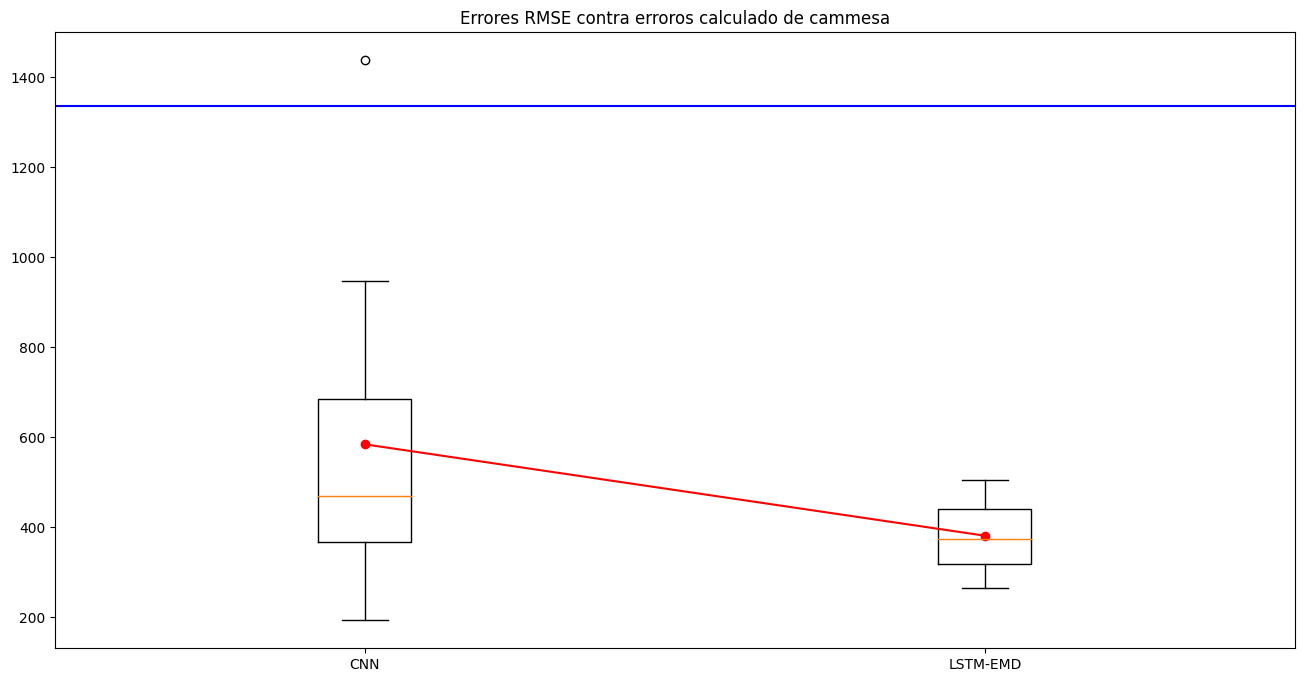

In [ ]:
# prompt: quiero superponer un grafico de lineas al diagrama de cajas y que la lienea continue hasta el final del diagrama de cajas

data=[list_cnn_rmse, list_lstm_emd_rmse]
rmse_cammesa = 1336.17879
# Calcular la media de cada conjunto de datos
means = [np.mean(d) for d in data]

# Crear una figura y un eje
fig, ax = plt.subplots()

# Crear el boxplot
plt.boxplot(data)
plt.xticks([1,2], ["CNN","LSTM-EMD"])
plt.title("Errores RMSE contra erroros calculado de cammesa")

# Graficar las medias como puntos y conectarlas con una línea
ax.plot(range(1, len(means)+1), means, 'ro-')


# Obtener los límites del eje x
x_limits = ax.get_xlim()

# Agregar la línea de CAMMESA extendida hasta el final del gráfico
ax.plot([x_limits[0], x_limits[1]], [rmse_cammesa, rmse_cammesa], 'b-')
ax.figure.set_size_inches(16, 8)

plt.show()


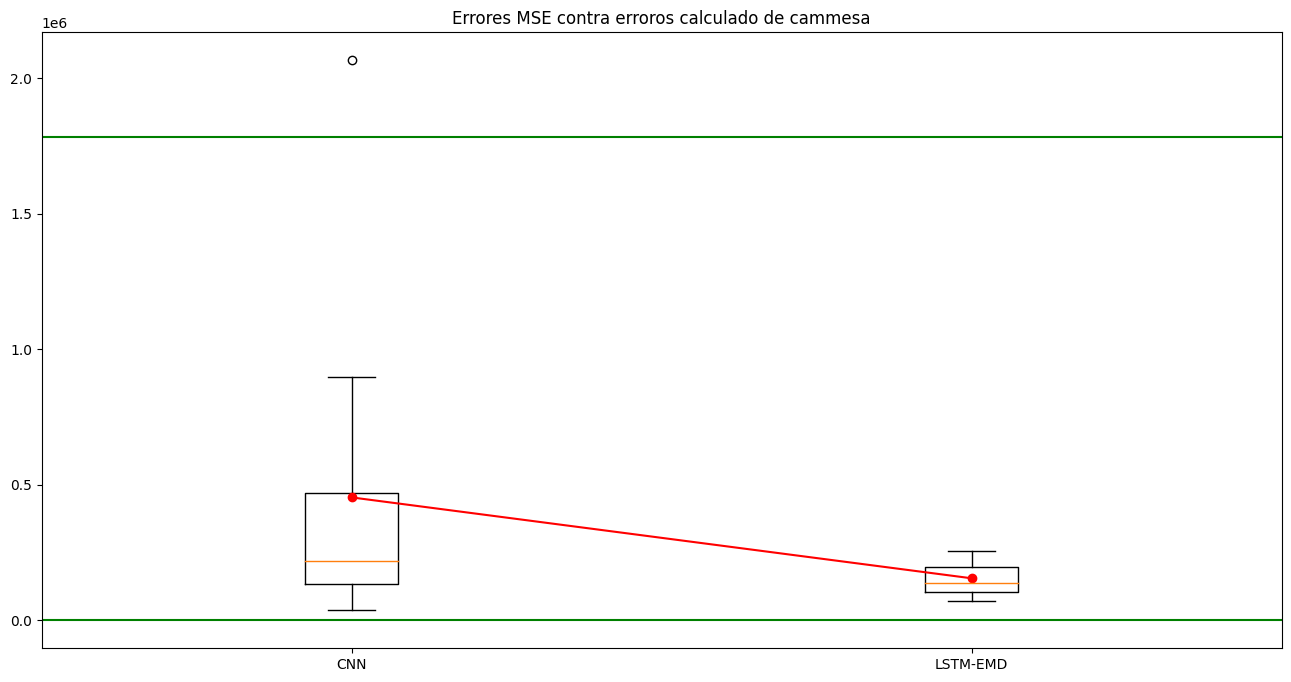

In [ ]:
# prompt: quiero superponer un grafico de lineas al diagrama de cajas y que la lienea continue hasta el final del diagrama de cajas

data=[list_cnn_mse, list_lstm_emd_mse]
mse_cammesa = 1785373,76
# Calcular la media de cada conjunto de datos
means = [np.mean(d) for d in data]

# Crear una figura y un eje
fig, ax = plt.subplots()

# Crear el boxplot
plt.boxplot(data)
plt.xticks([1,2], ["CNN","LSTM-EMD"])
plt.title("Errores MSE contra erroros calculado de cammesa")

# Graficar las medias como puntos y conectarlas con una línea
ax.plot(range(1, len(means)+1), means, 'ro-')

# Obtener los límites del eje x
x_limits = ax.get_xlim()

# Agregar la línea de CAMMESA extendida hasta el final del gráfico
ax.plot([x_limits[0], x_limits[1]], [mse_cammesa, mse_cammesa], 'g-')
ax.figure.set_size_inches(16, 8)

plt.show()

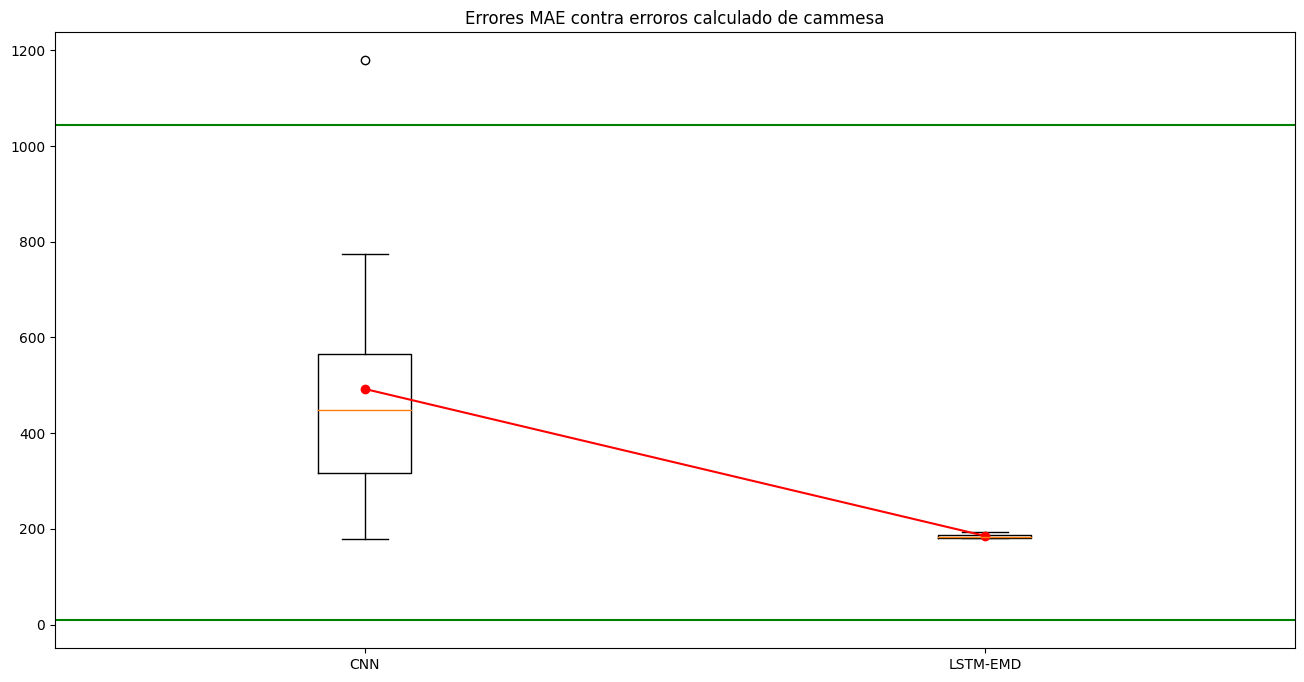

In [ ]:
# prompt: quiero superponer un grafico de lineas al diagrama de cajas y que la lienea continue hasta el final del diagrama de cajas

data=[list_cnn_mae, list_lstm_emd_mae]
mae_cammesa = 1044,9
# Calcular la media de cada conjunto de datos
means = [np.mean(d) for d in data]

# Crear una figura y un eje
fig, ax = plt.subplots()

# Crear el boxplot
plt.boxplot(data)
plt.xticks([1,2], ["CNN","LSTM-EMD"])
plt.title("Errores MAE contra erroros calculado de cammesa")

# Obtener los límites del eje x
x_limits = ax.get_xlim()

# Agregar la línea de CAMMESA extendida hasta el final del gráfico
ax.plot([x_limits[0], x_limits[1]], [mae_cammesa, mae_cammesa], 'g-')

# Graficar las medias como puntos y conectarlas con una línea
ax.plot(range(1, len(means)+1), means, 'ro-')

ax.figure.set_size_inches(16, 8)

plt.show()